In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from functools import partial

In [3]:
@partial(jax.jit, static_argnums=(2, 3))
def linear(pos : jnp.ndarray, weight : jnp.ndarray, grid_size : int, dx : float) -> jnp.ndarray:

    coords = jnp.linspace(start=0, stop=1, num=grid_size+1)

    grid = jnp.zeros((grid_size, grid_size, grid_size))

    # find position on the grid
    x_idx = jnp.digitize(pos[0], coords, right=True) - 1
    y_idx = jnp.digitize(pos[1], coords, right=True) - 1
    z_idx = jnp.digitize(pos[2], coords, right=True) - 1

    # assign the mass
    grid = grid.at[x_idx, y_idx, z_idx].set(weight / dx**3)

    return grid

In [21]:
def optimize(params, grid_star : jnp.ndarray, dx : float, n_steps : int) -> jnp.ndarray:
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]

    for i in range(n_steps):

        grid = linear(pos, weight, grid_size, dx)

        surface = (grid - grid_star)

        # get gradient of surface at particle position
        # 1. optain grid position

        coords = jnp.linspace(start=0, stop=1, num=grid_size+1)
        x_idx = jnp.digitize(pos[0], coords, right=True) - 1
        y_idx = jnp.digitize(pos[1], coords, right=True) - 1
        z_idx = jnp.digitize(pos[2], coords, right=True) - 1

        # 2. get gradient
        grad_x = surface[(x_idx+1)%grid_size, y_idx, z_idx] -\
            surface[x_idx-1, y_idx, z_idx]
        
        grad_y = surface[x_idx, (y_idx+1)%grid_size, z_idx] -\
            surface[x_idx, y_idx-1, z_idx]  
        
        grad_z = surface[x_idx, y_idx, (z_idx+1)%grid_size] -\
            surface[x_idx, y_idx, z_idx-1]
 
        grad = jnp.array([grad_x, grad_y, grad_z])

        # update position
        pos = pos - 0.01 * grad

        print(f"Step {i}, difference {jnp.sum(jnp.abs(surface))}")

    return {"pos" : pos, "weight" : weight}


In [24]:
N = 10
grid_size = 10
dx = 0.1

key = jax.random.key(0)

key_pos, key_weight = jax.random.split(key)

# create particles
pos = jax.random.uniform(key_pos, (3, N))
weight = jax.random.uniform(key_weight, (N,))

# assign particles 
grid_star = linear(pos, weight, grid_size, dx)

print(grid_star.mean())

3.3368976


Step 0, difference 8274.6953125
Step 1, difference 8274.6953125
Step 2, difference 8274.6953125
Step 3, difference 8274.6953125
Step 4, difference 8274.6953125
Step 5, difference 8274.6953125
Step 6, difference 8274.6953125
Step 7, difference 8274.6953125
Step 8, difference 8274.6953125
Step 9, difference 8274.6953125
Step 10, difference 8274.6953125
Step 11, difference 8274.6953125
Step 12, difference 8274.6953125
Step 13, difference 8274.6953125
Step 14, difference 8274.6953125
Step 15, difference 8274.6953125
Step 16, difference 8274.6953125
Step 17, difference 8274.6953125
Step 18, difference 8274.6953125
Step 19, difference 8274.6953125
Step 20, difference 8274.6953125
Step 21, difference 8274.6953125
Step 22, difference 8274.6953125
Step 23, difference 8274.6953125
Step 24, difference 8274.6953125
Step 25, difference 8274.6953125
Step 26, difference 8274.6953125
Step 27, difference 8274.6953125
Step 28, difference 8274.6953125
Step 29, difference 8274.6953125
Step 30, difference 

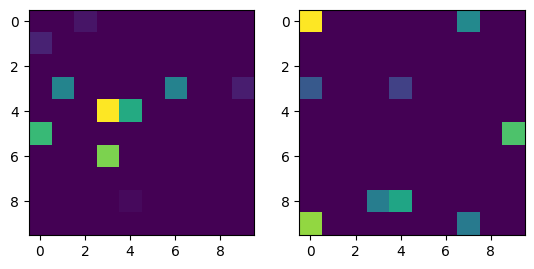

In [25]:
key = jax.random.key(1)

key_pos, key_weight = jax.random.split(key)

pos = jax.random.uniform(key_pos, (3, N)) 
weight = jax.random.uniform(key_weight, (N, ))

params_init = {
    'pos' : pos,
    'weight' : weight}


params = optimize(params_init, grid_star, dx, 100)

grid = linear(params["pos"], params["weight"], grid_size, 0.1)

# plot side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(grid_star.sum(axis=0))
plt.subplot(1, 2, 2)
plt.imshow(grid.sum(axis=0))
plt.show()

In [91]:
# # cic mass assignment
# def cic(pos : jnp.ndarray, weight : jnp.ndarray, grid_size : int, dx : float) -> jnp.ndarray:

#     coords = jnp.linspace(start=0, stop=1, num=grid_size+1)
#     x, y, z = jnp.meshgrid(coords, coords, coords)

#     grid = jnp.zeros((grid_size, grid_size, grid_size))

#     # find position on the grid
#     x_idx = jnp.digitize(pos[0], coords, right=True) - 1
#     y_idx = jnp.digitize(pos[1], coords, right=True) - 1
#     z_idx = jnp.digitize(pos[2], coords, right=True) - 1

#     x_cell = coords[x_idx]
#     y_cell = coords[y_idx]
#     z_cell = coords[z_idx]

#     # center values
#     values = (x - x_cell) * (y - y_cell) * (z - z_cell) * weight / dx**3
#     grid = grid.at[x_idx, y_idx, z_idx].set(values)

#     return grid

In [71]:
k1, k2 = jax.random.split(key)
rand = jax.random.uniform(k1, (100, 100, 100))
rand2 = jax.random.uniform(k2, (100, 100, 100))

print(jnp.mean((rand - jnp.zeros((100, 100, 100)))**2))

0.3333149
